In [1]:
import os
import numpy as np
import tensorflow.keras as keras
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm

plt.style.use('ggplot')

In [2]:
model_name = r"model_test.h5"
model_path =  r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\models"
load_path = r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\data\processed"

model_path = os.path.join(model_path, model_name)

class MonteCarloDropout(keras.layers.Dropout):
    """Keeps dropout on in testing mode for uncertainty predictions"""
    def call(self, inputs):
        return super().call(inputs, training=True)

model = keras.models.load_model(model_path, custom_objects={"f1_score": f1_score, "MonteCarloDropout": MonteCarloDropout})

with open(os.path.join(load_path, "processed_data.pickle"), "rb") as handle:
    combined_data = pickle.load(handle)

y_test = combined_data['y_test']
y_train = combined_data['y_train']

event_X_test = combined_data['event_X_test']
object_X_test = combined_data['object_X_test']

In [10]:
def vary_test_data(event_data, object_data, percentage):
    varied_event_data = event_data.copy()
    varied_object_data = vary_data(object_data, percentage)
    varied_event_data[:] = vary_data(event_data.values, percentage)

    return [varied_event_data, varied_object_data]


def vary_data(data, percentage):
    data_shape = data.shape
    random_array = (np.random.rand(*data_shape) - np.random.rand(*data_shape))
    
    offset = random_array * percentage * data
    varied_data = data + offset
    
    return varied_data


def get_predictions(n_bins):
    percentages = []
    scores = []
    
    for i in tqdm(range(0, n_bins)):
        percentage = i / n_bins
        varied_test_data = vary_test_data(event_X_test, object_X_test, percentage)
        
        preds = model.predict(varied_test_data).ravel()   
        auc = roc_auc_score(y_test, preds)        
        scores.append(auc)
        percentages.append(percentage)
    
    return (percentages, scores)

  0%|          | 0/20 [00:00<?, ?it/s]

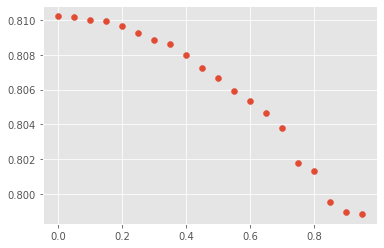

In [17]:
percentages, scores = get_predictions(20)
plt.scatter(percentages, scores)